In [1]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.metrics import *

warnings.filterwarnings('ignore')

In [2]:
brain_data = pd.read_csv('..b. Datasets/Brain Stroke/Brain Stroke.csv')

In [3]:
brain_data.shape

(4981, 11)

In [4]:
display(brain_data.head(2))
display(brain_data.tail(2))

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
4979,Male,40.0,0,0,Yes,Private,Rural,83.94,30.0,smokes,0
4980,Female,80.0,1,0,Yes,Private,Urban,83.75,29.1,never smoked,0


In [5]:
numerical_features = brain_data.select_dtypes(include='number').columns
categorical_features = brain_data.select_dtypes(include='object').columns

In [6]:
print("Number of numberical features:", len(numerical_features))
print("Number of categorical features:", len(categorical_features))

Number of numberical features: 6
Number of categorical features: 5


In [7]:
brain_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


In [8]:
brain_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,4981.0,43.419859,22.662755,0.08,25.00,45.00,61.00,82.00
hypertension,4981.0,0.096165,0.294848,0.00,0.00,0.00,0.00,1.00
heart_disease,4981.0,0.055210,0.228412,0.00,0.00,0.00,0.00,1.00
avg_glucose_level,4981.0,105.943562,45.075373,55.12,77.23,91.85,113.86,271.74
bmi,4981.0,28.498173,6.790464,14.00,23.70,28.10,32.60,48.90
stroke,4981.0,0.049789,0.217531,0.00,0.00,0.00,0.00,1.00


In [9]:
brain_data.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [10]:
import scipy.stats as stats

In [11]:
group1 = brain_data[brain_data['stroke'] == 1]['hypertension']
group2 = brain_data[brain_data['stroke'] == 0]['hypertension']
print(stats.ttest_ind(group1, group2))
a,b = stats.ttest_ind(group1, group2)
print(a,b)

TtestResult(statistic=9.393891028509634, pvalue=8.584820646961511e-21, df=4979.0)
9.393891028509634 8.584820646961511e-21


In [12]:
related_features = []
not_related_features = []

for feature in numerical_features:
    if feature == 'stroke':
        continue
    group1 = brain_data[brain_data['stroke'] == 1][feature]
    group2 = brain_data[brain_data['stroke'] == 0][feature]
    
    t_stat, p_val = stats.ttest_ind(group1, group2)
    significance_value = 0.05
    if p_val < significance_value:
        related_features.append(feature)
    else:
        not_related_features.append(feature)

print("Related features to 'Stroke' are", related_features)
print("Non-related features to 'Stroke' are", not_related_features)

Related features to 'Stroke' are ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
Non-related features to 'Stroke' are []


In [13]:
related_features = []
not_related_features = []

for feature in categorical_features:
    if feature == 'stroke':
        continue
    
    crosstab_val = pd.crosstab(brain_data[feature], brain_data['stroke'])
    chi2_stat = stats.chi2_contingency(crosstab_val)
    p_val = chi2_stat[1]
    significance_value = 0.05
    if p_val < significance_value:
        related_features.append(feature)
    else:
        not_related_features.append(feature)

print("Related features to 'Stroke' are", related_features)
print("Non-related features to 'Stroke' are", not_related_features)

Related features to 'Stroke' are ['ever_married', 'work_type', 'smoking_status']
Non-related features to 'Stroke' are ['gender', 'Residence_type']


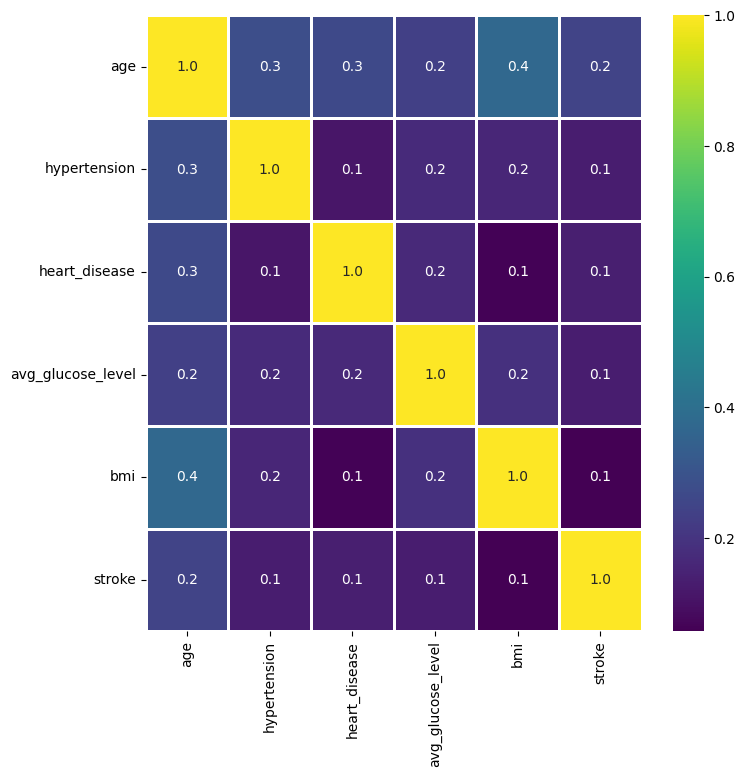

In [14]:
plt.figure(figsize=(8, 8))
sns.heatmap(brain_data[numerical_features].corr(), annot=True, fmt='.1f', cmap='viridis', linewidths=0.8)
plt.show()

In [15]:
correlation_matrix = brain_data[numerical_features].corr().abs()
cores_true = correlation_matrix[correlation_matrix > 0.3].isna() == False
true_pairs = cores_true.where(cores_true).stack().index.tolist()
print("Number of pairs with corr greater than 0.3 is", (len(true_pairs) - len(numerical_features)) // 2)

Number of pairs with corr greater than 0.3 is 1


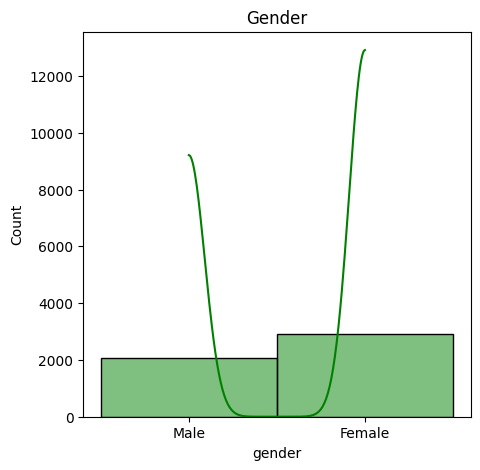

In [16]:
for feature in brain_data.columns:
    plt.figure(figsize=(5, 5))
    sns.histplot(data=brain_data, x=feature, color='green', kde=True)
    plt.title(feature.title())
    plt.show()
    break

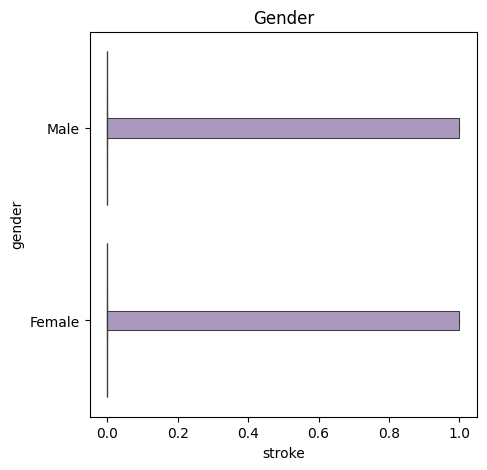

In [17]:
for feature in brain_data.columns:
    plt.figure(figsize=(5, 5))
    sns.boxenplot(data=brain_data, x='stroke', y=feature, color='rebeccapurple')
    plt.title(feature.title())
    plt.show()
    break

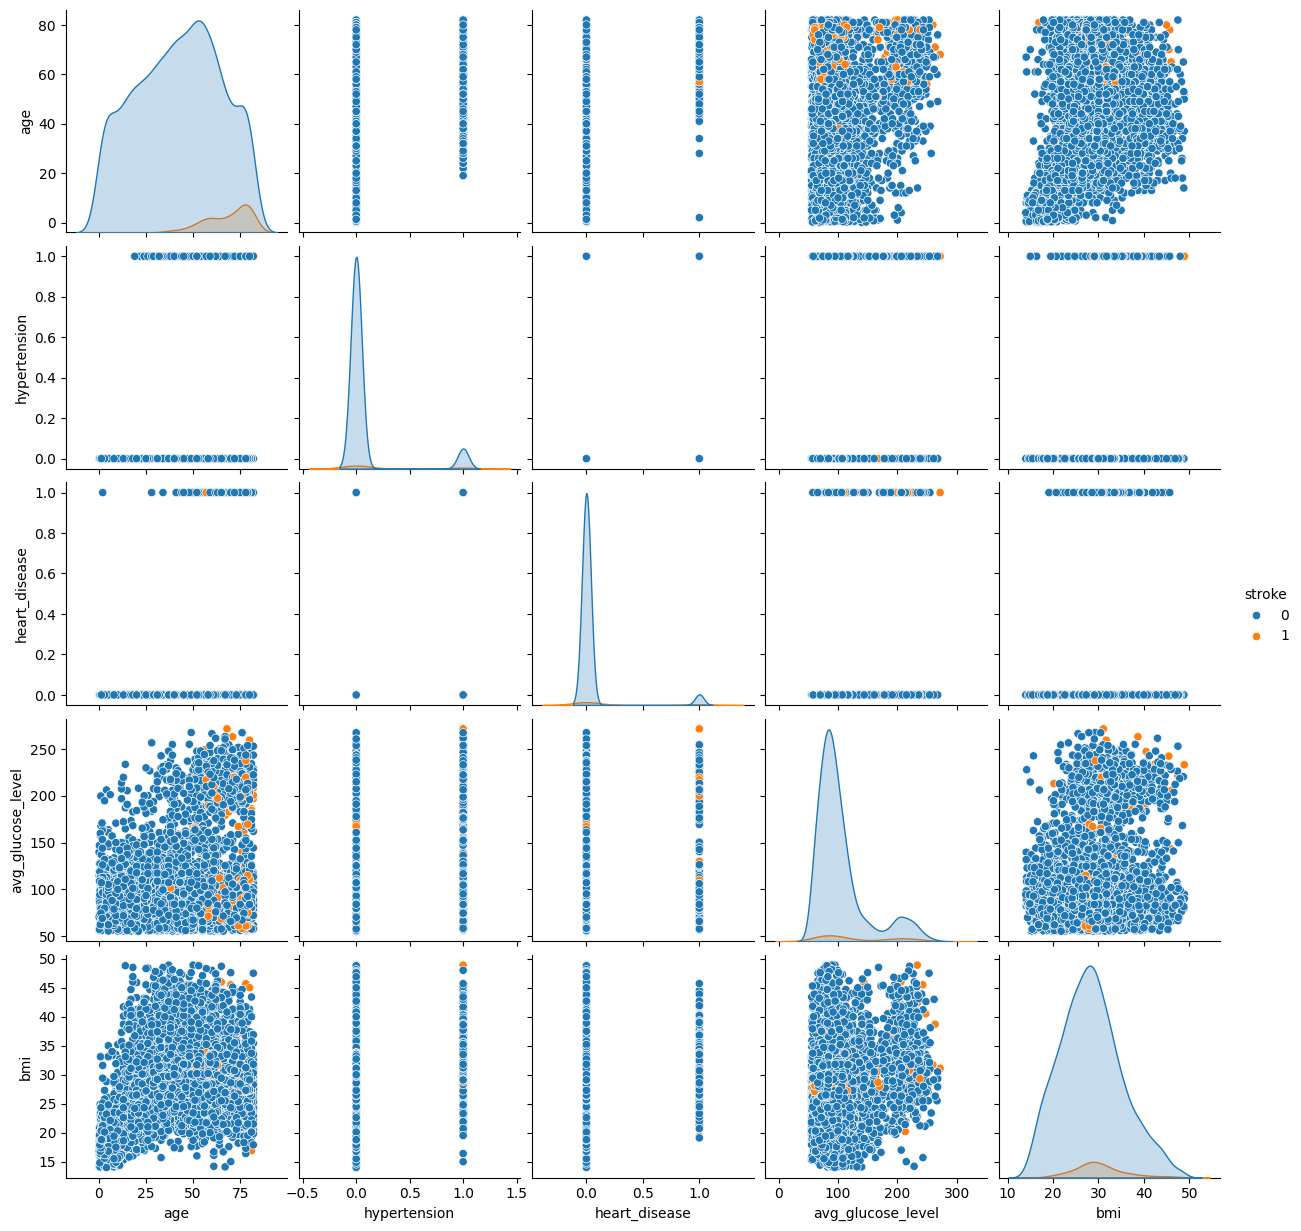

In [18]:
sns.pairplot(data=brain_data, hue='stroke')

In [19]:
for feature in brain_data.columns:
    print(f"\nFeature {feature} has {brain_data[feature].nunique()} unique values. They are: {brain_data[feature].unique()}")


Feature gender has 2 unique values. They are: ['Male' 'Female']

Feature age has 104 unique values. They are: [6.70e+01 8.00e+01 4.90e+01 7.90e+01 8.10e+01 7.40e+01 6.90e+01 7.80e+01
 6.10e+01 5.40e+01 5.00e+01 6.40e+01 7.50e+01 6.00e+01 7.10e+01 5.20e+01
 8.20e+01 6.50e+01 5.70e+01 4.20e+01 4.80e+01 7.20e+01 5.80e+01 7.60e+01
 3.90e+01 7.70e+01 6.30e+01 7.30e+01 5.60e+01 4.50e+01 7.00e+01 5.90e+01
 6.60e+01 4.30e+01 6.80e+01 4.70e+01 5.30e+01 3.80e+01 5.50e+01 4.60e+01
 3.20e+01 5.10e+01 1.40e+01 3.00e+00 8.00e+00 3.70e+01 4.00e+01 3.50e+01
 2.00e+01 4.40e+01 2.50e+01 2.70e+01 2.30e+01 1.70e+01 1.30e+01 4.00e+00
 1.60e+01 2.20e+01 3.00e+01 2.90e+01 1.10e+01 2.10e+01 1.80e+01 3.30e+01
 2.40e+01 3.60e+01 6.40e-01 3.40e+01 4.10e+01 8.80e-01 5.00e+00 2.60e+01
 3.10e+01 7.00e+00 1.20e+01 6.20e+01 2.00e+00 9.00e+00 1.50e+01 2.80e+01
 1.00e+01 1.80e+00 3.20e-01 1.08e+00 1.90e+01 6.00e+00 1.16e+00 1.00e+00
 1.40e+00 1.72e+00 2.40e-01 1.64e+00 1.56e+00 7.20e-01 1.88e+00 1.24e+00
 8.00e-01 4.0

In [20]:
brain_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


In [21]:
brain_data_encoded = pd.get_dummies(brain_data, drop_first=True, columns=categorical_features)

In [22]:
brain_data_encoded.head(2)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,True,True,True,False,False,True,True,False,False
1,80.0,0,1,105.92,32.5,1,True,True,True,False,False,False,False,True,False


In [23]:
brain_data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             4981 non-null   float64
 1   hypertension                    4981 non-null   int64  
 2   heart_disease                   4981 non-null   int64  
 3   avg_glucose_level               4981 non-null   float64
 4   bmi                             4981 non-null   float64
 5   stroke                          4981 non-null   int64  
 6   gender_Male                     4981 non-null   bool   
 7   ever_married_Yes                4981 non-null   bool   
 8   work_type_Private               4981 non-null   bool   
 9   work_type_Self-employed         4981 non-null   bool   
 10  work_type_children              4981 non-null   bool   
 11  Residence_type_Urban            4981 non-null   bool   
 12  smoking_status_formerly smoked  49

In [24]:
brain_data_encoded['stroke'] = brain_data_encoded['stroke'].astype('bool')

In [25]:
brain_data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             4981 non-null   float64
 1   hypertension                    4981 non-null   int64  
 2   heart_disease                   4981 non-null   int64  
 3   avg_glucose_level               4981 non-null   float64
 4   bmi                             4981 non-null   float64
 5   stroke                          4981 non-null   bool   
 6   gender_Male                     4981 non-null   bool   
 7   ever_married_Yes                4981 non-null   bool   
 8   work_type_Private               4981 non-null   bool   
 9   work_type_Self-employed         4981 non-null   bool   
 10  work_type_children              4981 non-null   bool   
 11  Residence_type_Urban            4981 non-null   bool   
 12  smoking_status_formerly smoked  49

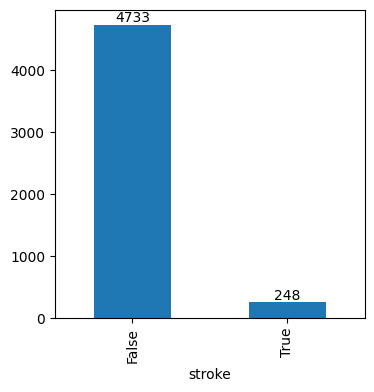

In [26]:
plt.figure(figsize=(4, 4))
barplot = brain_data_encoded.stroke.value_counts().plot(kind='bar')
plt.bar_label(barplot.containers[0], label_type='edge')
plt.show()

In [27]:
brain_data_encoded.stroke.value_counts() / len(brain_data) * 100

stroke
False    95.02108
True      4.97892
Name: count, dtype: float64

In [28]:
X = brain_data_encoded.drop(labels='stroke', axis=1)
y = brain_data_encoded['stroke']

In [29]:
X.shape

(4981, 14)

In [30]:
y.shape

(4981,)

In [31]:
smote = SMOTE()
X_up, y_up = smote.fit_resample(X, y)

In [32]:
X_up.shape

(9466, 14)

In [33]:
y_up.shape

(9466,)

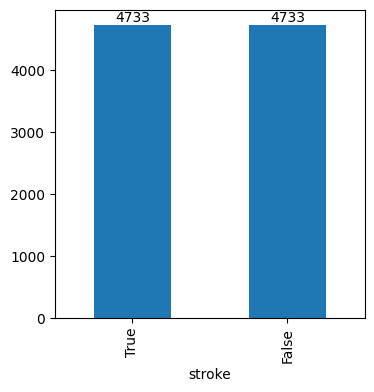

In [34]:
plt.figure(figsize=(4, 4))
barplot = y_up.value_counts().plot(kind='bar')
plt.bar_label(barplot.containers[0], label_type='edge')
plt.show()

In [35]:
under_sampler = RandomUnderSampler()
X_down, y_down = under_sampler.fit_resample(X, y)

In [36]:
X_down.shape

(496, 14)

In [37]:
y_down.shape

(496,)

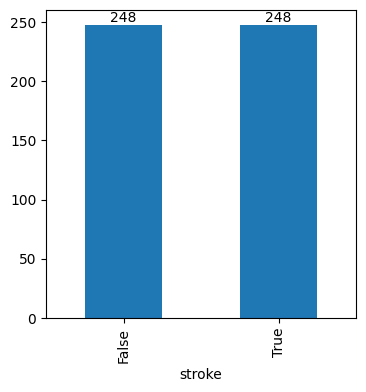

In [38]:
plt.figure(figsize=(4, 4))
barplot = y_down.value_counts().plot(kind='bar')
plt.bar_label(barplot.containers[0], label_type='edge')
plt.show()

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True, 
                                                    stratify=y, 
                                                    random_state=0, 
                                                    test_size=0.2)

In [40]:
rfc_model = RandomForestClassifier()
rfc_model.fit(X_train, y_train)
y_test_pred = rfc_model.predict(X_test)
acc = accuracy_score(y_test, y_test_pred)
print("Acc:", acc)
print(classification_report(y_test, y_test_pred))
confusion_matrix(y_test, y_test_pred)

Acc: 0.9478435305917753
              precision    recall  f1-score   support

       False       0.95      1.00      0.97       947
        True       0.00      0.00      0.00        50

    accuracy                           0.95       997
   macro avg       0.47      0.50      0.49       997
weighted avg       0.90      0.95      0.92       997



array([[945,   2],
       [ 50,   0]], dtype=int64)

In [41]:
X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(X_up, y_up, 
                                                                test_size=0.2, 
                                                                stratify=y_up, 
                                                                shuffle=True, 
                                                                random_state=0)

In [42]:
rfc_model = RandomForestClassifier()
rfc_model.fit(X_train_up, y_train_up)
y_train_up_pred_rfc = rfc_model.predict(X_train_up)
y_test_up_pred_rfc = rfc_model.predict(X_test_up)
acc = accuracy_score(y_test_up, y_test_up_pred_rfc)
print("Acc:", acc)
print(classification_report(y_test_up, y_test_up_pred_rfc))
confusion_matrix(y_test_up, y_test_up_pred_rfc)

Acc: 0.9577613516367476
              precision    recall  f1-score   support

       False       0.96      0.95      0.96       947
        True       0.95      0.96      0.96       947

    accuracy                           0.96      1894
   macro avg       0.96      0.96      0.96      1894
weighted avg       0.96      0.96      0.96      1894



array([[903,  44],
       [ 36, 911]], dtype=int64)

In [43]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train_up, y_train_up)
y_train_up_pred_xgb = xgb_model.predict(X_train_up) 
y_test_up_pred_xgb = xgb_model.predict(X_test_up)
acc = accuracy_score(y_test_up, y_test_up_pred_xgb)
print("Accuracy", acc)

Accuracy 0.9498416050686378


In [44]:
from sklearn.linear_model import LogisticRegression

stacked_features = pd.DataFrame({
                        'random_forest_model': y_train_up_pred_rfc,
                        'xg_boost_model': y_train_up_pred_xgb
                    })

meta_model = LogisticRegression()
meta_model.fit(stacked_features, y_train_up)

stacked_test_features = pd.DataFrame({
    'random_forest_model': y_test_up_pred_rfc,
    'xg_boost_model': y_test_up_pred_xgb
})

# Predict on test set
y_meta_pred = meta_model.predict(stacked_test_features)

acc = accuracy_score(y_test_up, y_meta_pred)
print("Acc", acc)

Acc 0.9577613516367476


In [45]:
rfc_model = RandomForestClassifier()
xgb_model = XGBClassifier()
meta_model = LogisticRegression()

# Create a Voting Classifier (Hard Voting)
voting_clf = VotingClassifier(estimators=[
    ('random_forest', rfc_model),
    ('xg_boost', xgb_model),
    ('logistic_regression', meta_model)
], voting='hard')  # Can use 'soft' if you want probability-based voting

# Train on the full training dataset
voting_clf.fit(X_train_up, y_train_up)

# Predict on test set
y_pred = voting_clf.predict(X_test_up)

# Evaluate accuracy
acc = accuracy_score(y_test_up, y_pred)
print("Accuracy:", acc)

Accuracy: 0.9530095036958818


In [46]:
sfs_selector = sfs(estimator=rfc_model, 
                   k_features=7, 
                   cv=3)
sfs_selector.fit(X_train, y_train)

SequentialFeatureSelector(cv=3, estimator=RandomForestClassifier(),
                          k_features=(7, 7), scoring='accuracy')

In [47]:
best_features = sfs_selector.k_feature_names_
best_features

('age',
 'hypertension',
 'gender_Male',
 'ever_married_Yes',
 'work_type_children',
 'Residence_type_Urban',
 'smoking_status_smokes')

In [48]:
X_up_k = X_up[list(best_features)]
y_up_k = y_up

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_up_k, y_up_k, 
                                                    shuffle=True, 
                                                    stratify=y_up_k, 
                                                    random_state=0, 
                                                    test_size=0.3)

In [50]:
rfc_model = RandomForestClassifier()
param_gridly = {
    'n_estimators': range(100, 500, 100),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': range(3, 10, 2)
}

k_fold_cv = KFold(n_splits=3, shuffle=True, random_state=0)

randomised_search_cv = RandomizedSearchCV(estimator=rfc_model, 
                                          param_distributions=param_gridly,
                                          scoring='accuracy', 
                                          random_state=0, 
                                          n_jobs=-1, 
                                          verbose=1, 
                                          cv=k_fold_cv)

In [51]:
randomised_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=0, shuffle=True),
                   estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': range(3, 10, 2),
                                        'n_estimators': range(100, 500, 100)},
                   random_state=0, scoring='accuracy', verbose=1)

In [52]:
y_test_pred = randomised_search_cv.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.8545774647887324

In [53]:
standard_scaler = StandardScaler()
train_feature_names = X_train.columns
test_feature_names = X_test.columns

X_train = pd.DataFrame(data=standard_scaler.fit_transform(X_train), 
                       columns=train_feature_names)
X_test = pd.DataFrame(data=standard_scaler.transform(X_test), 
                      columns=test_feature_names)

In [54]:
rfc_model = RandomForestClassifier()
param_gridly = {
    'n_estimators': range(100, 500, 100),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': range(3, 10, 2)
}

k_fold_cv = KFold(n_splits=3, shuffle=True, random_state=0)

randomised_search_cv = RandomizedSearchCV(estimator=rfc_model, 
                                          param_distributions=param_gridly,
                                          scoring='accuracy', 
                                          random_state=0, 
                                          n_iter=15,
                                          n_jobs=-1, 
                                          verbose=1, 
                                          cv=k_fold_cv)

In [55]:
randomised_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=0, shuffle=True),
                   estimator=RandomForestClassifier(), n_iter=15, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': range(3, 10, 2),
                                        'n_estimators': range(100, 500, 100)},
                   random_state=0, scoring='accuracy', verbose=1)

In [56]:
y_test_pred = randomised_search_cv.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.85

In [57]:
recall_score(y_test, y_test_pred)

0.8838028169014085

In [58]:
submission_df = pd.DataFrame({
    'Index': X_test_up.index, 
    'Stroke': y_pred
})

In [59]:
submission_df.sort_values(by='Index', ascending=True, inplace=True)
submission_df.head(2)

,Index,Stroke
1716,1,False
1278,4,True


In [60]:
submission_df.to_csv("../d. Output Files/Brain Stroke/Brain Stroke Prediction.csv", index='False')